<a href="https://colab.research.google.com/github/paulamartingonzalez/GNNs-cox/blob/main/final_version_DGL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time to Event Prediction using Graph Neural Networks:



This is an extension of this [pycox tutorial with CNNs](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/04_mnist_dataloaders_cnn.ipynb) to make it work with graph neural networks. It works with DGL at the moment

## Install and load packages

In [1]:
!pip install dgl 

     |████████████████████████████████| 4.4 MB 33.4 MB/s 


In [2]:
!pip install pycox

     |████████████████████████████████| 73 kB 2.6 MB/s 
     |████████████████████████████████| 65 kB 4.7 MB/s 
     |████████████████████████████████| 41 kB 798 kB/s 
     |████████████████████████████████| 2.2 MB 59.2 MB/s 
     |████████████████████████████████| 357 kB 42.1 MB/s 
     |████████████████████████████████| 124 kB 66.0 MB/s 
     |████████████████████████████████| 1.9 MB 35.8 MB/s 


In [3]:
!pip install torchtuples 

In [4]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader 

# MNIST is part of torchvision
from torchvision import datasets, transforms
from random import randint
import numpy as np
from dgl.nn import GraphConv
import torchtuples as tt
from pycox.models import LogisticHazard
from pycox.utils import kaplan_meier
from pycox.evaluation import EvalSurv
from torch.utils.data import DataLoader

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: pytorch


In [5]:
tt.__version__

'0.2.2'

## Simulate data

### Time and event (y/n)

In [6]:
def sim_event_times(max_time=700):
    digits = []
    for _ in range(25):
        rnum = randint(0, 10)
        digits.append(float(rnum))
    digits = np.asarray(digits)
    betas = 365 * np.exp(-0.6 * digits) / np.log(1.2)
    event_times = np.random.exponential(betas)
    censored = event_times > max_time
    event_times[censored] = max_time

    return tt.tuplefy(event_times, ~censored)




In [7]:
sim_train = sim_event_times()
sim_test = sim_event_times()

In [8]:
labtrans = LogisticHazard.label_transform(20)
target_train = labtrans.fit_transform(*sim_train)
target_test = labtrans.transform(*sim_test)


### Create random graphs (with 20 nodes and 4 node features)

In [9]:
gs=[]
for i in range(25):
    g = dgl.graph((torch.randint(0, 20, (100,)), torch.randint(0, 20, (100,))), num_nodes=20)
    g = dgl.add_reverse_edges(g)
    g = dgl.remove_self_loop(g)
    #g = dgl.add_self_loop(g)
    g.ndata['h_n'] = torch.randn(g.num_nodes(), 4)
    
    gs.append((g,(torch.tensor(target_train[0][i]),torch.tensor(target_train[1][i])))) 


In [10]:
gs_test=[]
for i in range(25):
    g = dgl.graph((torch.randint(0, 20, (100,)), torch.randint(0, 20, (100,))), num_nodes=20)
    g = dgl.add_reverse_edges(g)
    g = dgl.remove_self_loop(g)
    #g = dgl.add_self_loop(g)
    g.ndata['h_n'] = torch.randn(g.num_nodes(), 4)
    
    gs_test.append((g,(torch.tensor(target_train[0][i]),torch.tensor(target_train[1][i])))) 

gs has shape: (graph,(time,event)),(graph,(time,event)),(graph,(time,event)),...

### Custom collate function

In [11]:
def collate(samples):
    graphs, labels = map(list, zip(*samples)) # you could just do zip(*samples)
    batched_graph = dgl.batch(graphs)
    return batched_graph, tt.tuplefy(labels).stack()

In [12]:
batch = [gs[0], gs[1]]
collate(batch)

(Graph(num_nodes=40, num_edges=374,
       ndata_schemes={'h_n': Scheme(shape=(4,), dtype=torch.float32)}
       edata_schemes={}), (tensor([1, 1]), tensor([1., 1.])))

### Dataloaders

In [13]:

data_loader = DataLoader(gs, batch_size=int(10), shuffle=True,
                            collate_fn=collate)
test_data_loader = DataLoader(gs_test, batch_size=int(10), shuffle=True,collate_fn=collate)

# Training

##  Define model

In [14]:
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)
    def forward(self, g):
            in_feat = g.ndata['h_n'].float()
            h = self.conv1(g, in_feat)
            h = F.relu(h)
            h = self.conv2(g, h)
            g.ndata['h'] = h
            return dgl.mean_nodes(g, 'h')

In [15]:
net = GCN(4, 16, labtrans.out_features)
batch = next(iter(data_loader))
x, y = batch
net(x)

tensor([[-4.5794e-02,  8.6477e-02,  5.5732e-02, -6.3307e-02,  1.8604e-03,
         -1.5302e-01,  1.5903e-02, -7.4000e-02, -6.9730e-02, -1.7162e-02,
          7.2923e-02,  8.3221e-02, -3.7533e-02, -1.1566e-01,  8.2875e-02,
         -9.3121e-02,  1.5381e-03,  2.8615e-02,  1.7524e-01, -2.1946e-02],
        [-5.2044e-02,  1.2953e-01, -2.7418e-02, -1.1707e-01,  9.2657e-02,
         -1.5501e-01,  1.1506e-01, -1.7365e-01, -1.5935e-01, -1.9717e-02,
         -2.2669e-02,  2.3560e-03, -1.1470e-01, -1.6384e-01, -1.1166e-02,
         -1.8670e-01, -3.0518e-02, -3.4080e-02,  3.2733e-01,  5.9036e-02],
        [-4.2378e-02,  5.8312e-02, -3.5537e-02,  3.1402e-02,  1.7470e-02,
         -4.1884e-02, -3.7603e-03, -1.1941e-02, -4.9609e-02,  5.2181e-02,
          6.2873e-02, -3.7718e-03,  9.0500e-03, -7.2232e-02,  3.2381e-02,
         -2.1242e-02,  1.9013e-02,  2.6604e-02,  9.0883e-02, -4.8537e-02],
        [-3.8813e-02,  1.4114e-01, -1.2298e-01, -4.8441e-02,  1.0499e-01,
         -1.0974e-01,  7.8053e-02, 

## Train

In [16]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

In [17]:
callbacks = [tt.cb.EarlyStopping(patience=5)]
epochs = 50
verbose = True
log = model.fit_dataloader(data_loader, epochs, callbacks, verbose, val_dataloader=test_data_loader)

0:	[0s / 0s],		train_loss: 5.8121,	val_loss: 6.0089
1:	[0s / 0s],		train_loss: 5.9061,	val_loss: 6.2271
2:	[0s / 0s],		train_loss: 5.6763,	val_loss: 5.6877
3:	[0s / 0s],		train_loss: 5.6818,	val_loss: 5.0862
4:	[0s / 0s],		train_loss: 5.0113,	val_loss: 4.9631
5:	[0s / 0s],		train_loss: 4.8330,	val_loss: 4.6452
6:	[0s / 0s],		train_loss: 4.4345,	val_loss: 4.1580
7:	[0s / 0s],		train_loss: 3.9018,	val_loss: 3.6247
8:	[0s / 0s],		train_loss: 3.3587,	val_loss: 3.2816
9:	[0s / 0s],		train_loss: 3.0296,	val_loss: 2.9614
10:	[0s / 0s],		train_loss: 2.8445,	val_loss: 2.7127
11:	[0s / 0s],		train_loss: 2.5309,	val_loss: 2.4592
12:	[0s / 0s],		train_loss: 2.3359,	val_loss: 2.2850
13:	[0s / 0s],		train_loss: 2.1859,	val_loss: 2.2432
14:	[0s / 0s],		train_loss: 2.0022,	val_loss: 2.0329
15:	[0s / 0s],		train_loss: 1.9066,	val_loss: 2.1036
16:	[0s / 0s],		train_loss: 1.9142,	val_loss: 2.0974
17:	[0s / 0s],		train_loss: 2.0406,	val_loss: 2.0729
18:	[0s / 0s],		train_loss: 1.8225,	val_loss: 1.9778
19:

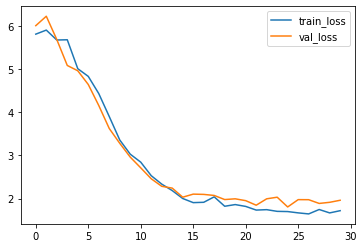

In [18]:
_ = log.plot()

# Define test set and evaluate performance

In [19]:
def collate_x(samples):
    graphs, labels = map(list, zip(*samples)) # you could just do zip(*samples)
    batched_graph = dgl.batch(graphs)
    return batched_graph

In [20]:
batch = [gs_test[0], gs_test[1]]
collate_x(batch)

Graph(num_nodes=40, num_edges=386,
      ndata_schemes={'h_n': Scheme(shape=(4,), dtype=torch.float32)}
      edata_schemes={})

In [21]:
test_data_loader_x = DataLoader(gs_test, batch_size=int(10), shuffle=True,collate_fn=collate_x)

In [22]:
model.predict(test_data_loader_x)

array([[-4.798245  , -0.92118704, -3.5816798 , -4.186797  , -2.0678196 ,
        -4.117856  , -2.2151127 , -1.1830494 , -4.821149  , -4.1638484 ,
        -4.4167624 , -4.6782527 , -2.5513194 , -5.1251745 , -4.6410313 ,
        -4.5474567 , -1.6552509 , -4.662274  , -2.3635573 , -4.332309  ],
       [-4.6886435 , -0.5205902 , -3.5594401 , -4.3803973 , -1.8799019 ,
        -4.4341598 , -1.6324934 , -1.3669941 , -4.730414  , -4.149429  ,
        -4.3998413 , -4.7482    , -2.302448  , -4.606675  , -4.5702314 ,
        -4.757222  , -2.3080206 , -4.3208456 , -1.8888766 , -4.180713  ],
       [-4.4625587 , -0.61779594, -3.5426433 , -4.1573935 , -1.7108543 ,
        -4.1538086 , -1.6021783 , -1.2581296 , -4.5026846 , -3.930956  ,
        -4.193631  , -4.645611  , -2.1352415 , -4.403216  , -4.338202  ,
        -4.5607085 , -2.0640693 , -4.0638685 , -1.9025398 , -4.084797  ],
       [-4.736859  , -0.45002803, -3.3850684 , -4.565425  , -1.9420302 ,
        -4.5737114 , -1.6194706 , -1.6121035 , -

In [23]:
surv = model.predict_surv_df(test_data_loader_x)

In [24]:
surv = model.interpolate(10).predict_surv_df(test_data_loader_x)

In [25]:
ev = EvalSurv(surv, *sim_test, 'km')

In [26]:
ev.concordance_td()

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


0.47278911564625853